In [1]:
%matplotlib inline
from auto_binary_classifier import *

## auto_binary_classifier

The auto_binary_classifier class is an all encompassing binary classification that allows a user to automatically:

* <b>Preprocess their data</b>
    * one hot or label encoding (particularly for tree vs non tree based models)
        * Unless if there is some type of ordinal relationship, I try to avoid label encoding for non tree sklearn models. For Keras, I normally work with word embedding layers or arrays of label encoded strings(or multilabel biniarizer)
    * it determines whether the data has class imbalance
    * drop columns with weird distributions such as _pymnt_plan_ and _initial_list_status_
    * drops columns that have to many categories(such as Id)
    * imputes missing values and drops columns with too many missing values
    
* <b>Adjusts for class imbalance issues</b>
    * if the program determines that there is significant class imbalance, it will automatically adjust this for user by considering:
        * random undersampling - it does a 50/50 undersample split by default, but the user can specify number of rows, n_rows
        * SMOTE
    * it then computes which class imbalance technique yields the best recall
    
* <b>Dimensionality reduction</b>
    * allows the user to choose the desired number of features. This is particularly important for cases in which one hot encoding is involved
    * Note: I built out an autoencoder in addition to a feature selection(I personally avoid PCA as far as binary features). I ended up choosing feature selection by default because the autoencoder kept underperforming in all cases
    * other methods for dimension reduction include TNSE and UMAP
    
* <h4>Lastly, it automatically chooses the best Model(and the best sampling technique)</h4>  
    * This package considers the following (vanilla)classifiers: 
        * Logistic Regression
        * SVM
        * Random Forest
        * Xgboost
        * Sequential model via Keras
    * for each model I evaluation k=5 folds and consider the model with the highest accuracy(or recall if class imbalance) and lowest deviation in scores    
    * The end result looks something like this
    
    ```{'sampling_method': 'random_undersample',
     'classifier': 'xgboost',
     'evaluation_metric': 'recall',
     'std': 0.03,
     'mean_accuracy': 0.61,
     'execution_time': 1.1010563373565674}
     ```    
    * Moreover, we can check out the results of all other models within binary_classification_results.pkl
        
    
<p><b>Things I would've love to build out if I had more time:</b></p> 
* after finding the best model, I would like to do grid search to optimize it more
* UMAP, particularly for sparse matrices. So instead of just comparing sampling methods by model, I would also test out more dimensionality techniques. I tend to prefer using latent representation of information rather than removal
* adjusting for multiclass problems. I started building out the functionality to determine class imbalance on a multiclass level and automate understanding the distribution for each class but I ran out of time

* unit tests - due to time constraints, I was mostly using other uci datasets such as their default credit dataset or the titanic dataset to weed out any bugs



### Short Answered Questions:

1. I would go with a Logistic Regression since banks are highly regulartory, therefore, they need more transparency on what's being fed into the model. It is very easy to interpret the features as far as Logistic regression. Whereas nerual nets leverage more predictive power rather than interpretability 

2. They could look at the weights, whether it be coef or feature_importance via a RF. If the customer got stuck, I would probably just send them the function, feature_selection I used in scale_features.py in but instead of returning a transformed dataframe, I could have it return the top_features list

### First, let's read in our data

In [3]:
df = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club_reduced.csv")
df.head(3)

,Id,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,10,MORTGAGE,50000.0,not verified,n,medical,766xx,TX,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,1,RENT,39216.0,not verified,n,debt consolidation,660xx,KS,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,4,RENT,65000.0,not verified,n,credit card,916xx,CA,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4


### Getting started

Note: num_output_features is the number of features in my final dataframe

In [4]:
binary_classifer = auto_binary_classifier(df=df,target_column='is_bad',num_output_features=300)

lets look at how it preprocesses data for a non tree model vs tree

In [7]:
help(binary_classifer.data_preprocessing)

Help on method data_preprocessing in module __main__:

data_preprocessing(tree_based) method of __main__.auto_binary_classifier instance
    This function this returns the dataframe with one hot encoded/label encoded features, dimensionally reduced features, 
    dropping features that have weird distributions, scaling continous variables and 
    imputing any nan(and dropping columns that have too many nans)
    
    Parameters
    ----------
    df : pandas dataframe
        this is the data
    
    target_column : string
        the target variable name
    
    tree_based  :  boolean
        set to False by default. Set tree_based=True if you're working with a tree based model(i.e RF, xgboost,etc.)        
        
    num_output_features  :  int
        number of output features desired as far as dimensionality reduction
        
    dimension_reduction_method  :  string    
        'autoencoder' or 'feature_selection'
    n_rows  :  int
        number of rows desired as far as r

In [5]:
#for tree based models
binary_classifer.data_preprocessing(True)

double check category [4] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,revol_util,total_acc,debt_to_income,open_acc,zip_code,annual_inc,purpose_cat,emp_length,addr_state,inq_last_6mths,policy_code,mths_since_last_major_derog,home_ownership,delinq_2yrs,verification_status,pub_rec,is_bad
0,0.120278,0.483146,0.362454,0.368421,0.771905,0.053452,0.538462,0.076923,0.857143,0.00,0.75,0.0,0.0,0.000000,1.0,0.000000,0
1,0.636183,0.044944,0.305102,0.078947,0.677330,0.041443,0.153846,0.000000,0.326531,0.08,0.00,0.5,1.0,0.000000,1.0,0.000000,0
2,0.005964,0.078652,0.374792,0.078947,0.902643,0.070156,0.076923,0.538462,0.081633,0.00,0.75,1.0,1.0,0.000000,1.0,0.000000,0
3,0.368787,0.247191,0.206069,0.131579,0.122392,0.061804,0.153846,0.076923,0.673469,0.00,0.25,0.5,0.0,0.090909,1.0,0.000000,0
4,0.401590,0.224719,0.634545,0.184211,0.484006,0.053457,0.153846,0.076923,0.693878,0.16,0.50,1.0,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.239563,0.101124,0.313438,0.184211,0.006954,0.071548,0.961538,0.615385,0.387755,0.04,0.50,0.5,0.0,0.000000,0.0,0.000000,0
9996,0.585487,0.123596,0.683228,0.184211,0.105702,0.026726,0.153846,0.000000,0.673469,0.04,0.50,0.5,1.0,0.000000,0.5,0.000000,0
9997,0.603380,0.179775,0.804602,0.210526,0.061196,0.051037,0.153846,0.846154,0.612245,0.00,0.50,1.0,1.0,0.000000,1.0,0.333333,0
9998,0.505964,0.292135,0.539513,0.210526,0.272601,0.075724,0.461538,0.692308,0.897959,0.08,0.50,0.5,0.0,0.181818,1.0,0.000000,0


In [44]:
#for non tree data prep
binary_classifer.data_preprocessing(False)

C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,purpose_cat__debt consolidation small business,purpose_cat__small business small business,purpose_cat__other small business,annual_inc,purpose_cat__credit card small business,purpose_cat__home improvement small business,purpose_cat__wedding,emp_length__22,purpose_cat__credit card,purpose_cat__educational,...,emp_length__2,zip_code__275xx,zip_code__902xx,home_ownership__OWN,addr_state__WI,zip_code__322xx,zip_code__329xx,zip_code__070xx,zip_code__950xx,is_bad
0,0,0,0,0.053452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0.041443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0.070156,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0.061804,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0.053457,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0.071548,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0.026726,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0.051037,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9998,0,0,0,0.075724,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I also incorporated some plots just in case a user would like to quickly visualize the distribution of a particular categorical column

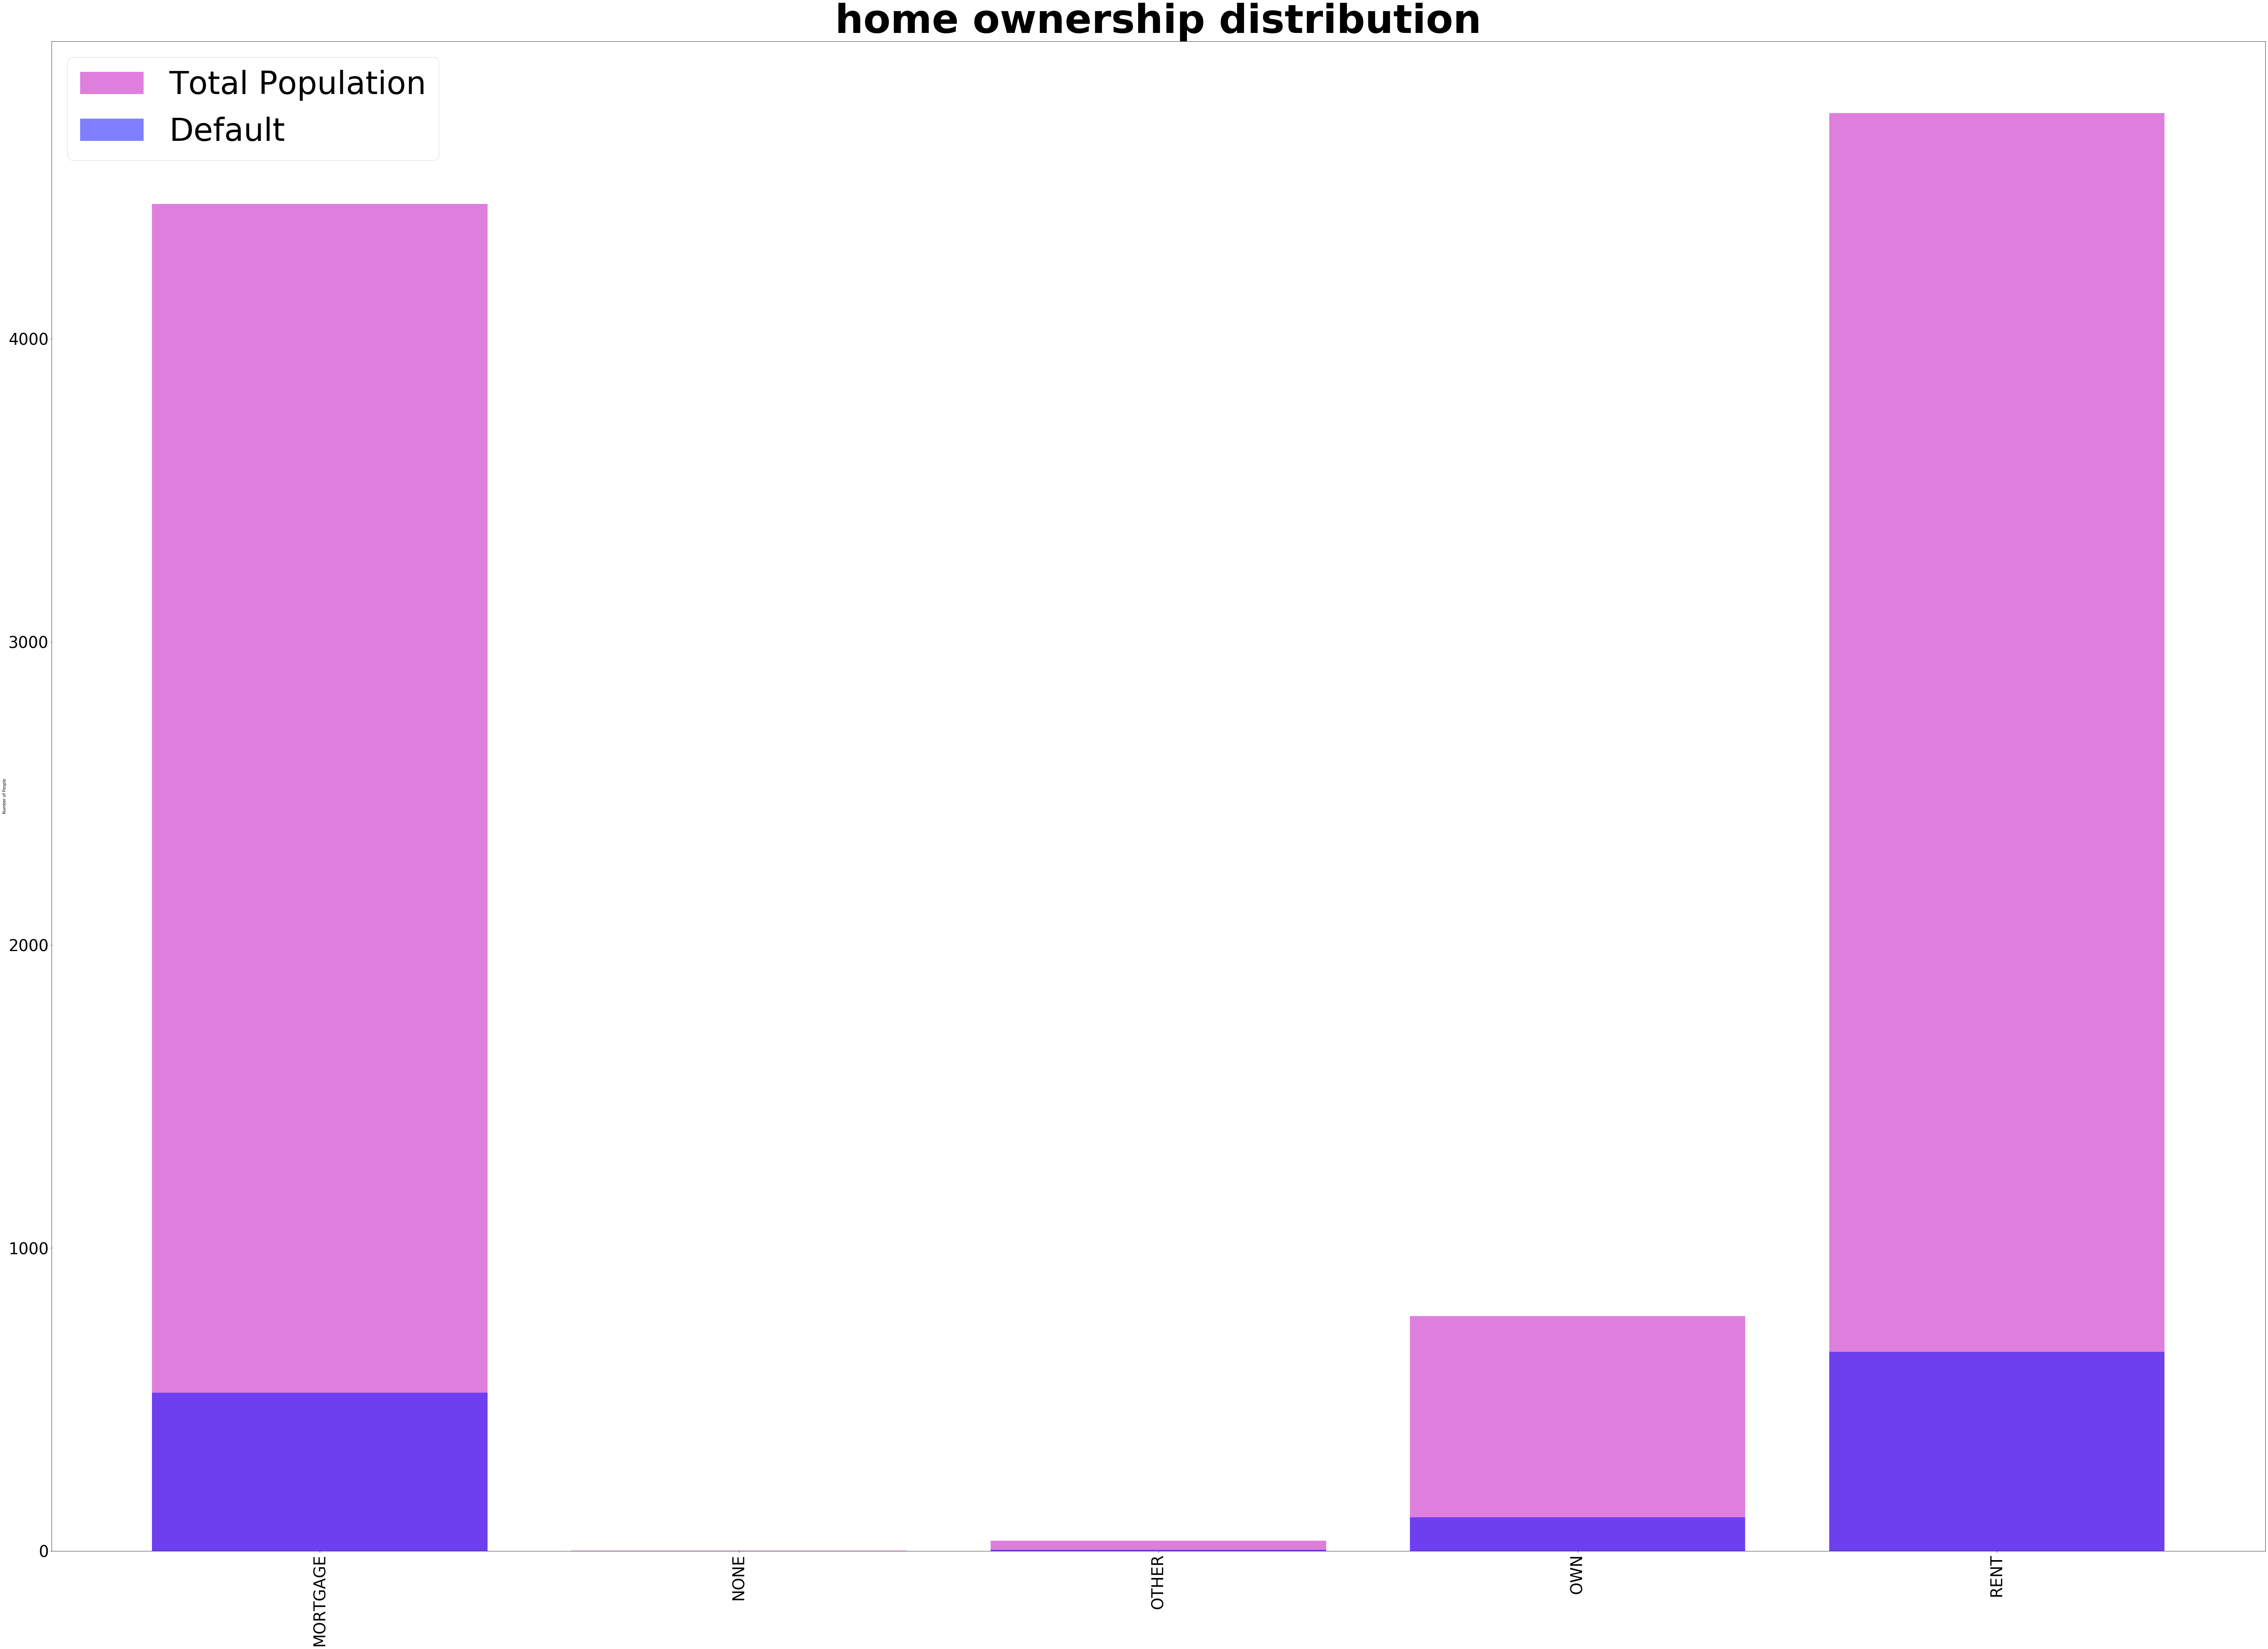

In [11]:
plot_categorical_column('home_ownership','is_bad',pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club_reduced.csv"))

#### Unit Testing

I didn't have a chance to write formal unit tests but what I did to make sure my code was error free was test different types of datasets that also included binary classification

#### ex.)

In [13]:
df1 = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls',header=1)
df1 = df1.rename(columns={'default payment next month': 'default'})
df1.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [15]:
binary_classifer = auto_binary_classifier(df=df1,target_column='default',num_output_features=300)

In [16]:
binary_classifer.data_preprocessing(True)

double check category [6] from the column called EDUCATION
double check category [3] from the column called MARRIAGE


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,PAY_0,LIMIT_BAL,AGE,BILL_AMT1,PAY_AMT6,BILL_AMT3,BILL_AMT2,BILL_AMT6,PAY_AMT1,BILL_AMT4,...,PAY_AMT3,PAY_AMT2,PAY_3,EDUCATION,PAY_4,PAY_6,PAY_5,MARRIAGE,SEX,default
0,0.4,0.0250,0.054545,0.149982,0.000000,0.086723,0.069164,0.260979,0.000000,0.160138,...,0.000000,0.000409,0.1,0.333333,0.1,0.000000,0.000000,0.333333,1.0,1
1,0.1,0.1500,0.090909,0.148892,0.003783,0.087817,0.067858,0.263485,0.000000,0.163220,...,0.001116,0.000594,0.2,0.333333,0.2,0.333333,0.222222,0.666667,1.0,1
2,0.2,0.1125,0.236364,0.172392,0.009458,0.093789,0.079532,0.272928,0.001738,0.173637,...,0.001116,0.000891,0.2,0.333333,0.2,0.222222,0.222222,0.666667,1.0,0
3,0.2,0.0625,0.290909,0.188100,0.001892,0.113407,0.111995,0.283685,0.002290,0.186809,...,0.001339,0.001199,0.2,0.333333,0.2,0.222222,0.222222,0.333333,1.0,0
4,0.1,0.0625,0.654545,0.154144,0.001284,0.106020,0.071601,0.275681,0.002290,0.179863,...,0.011160,0.021779,0.1,0.333333,0.2,0.222222,0.222222,0.333333,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.2,0.2750,0.327273,0.313716,0.001892,0.200746,0.249208,0.273259,0.009730,0.243036,...,0.005583,0.011875,0.2,0.500000,0.2,0.222222,0.222222,0.333333,0.0,0
29996,0.1,0.1875,0.400000,0.148008,0.000000,0.088267,0.067955,0.260979,0.002103,0.168596,...,0.010042,0.002094,0.1,0.500000,0.1,0.222222,0.222222,0.666667,0.0,0
29997,0.6,0.0375,0.290909,0.149674,0.005864,0.087859,0.069405,0.275854,0.000000,0.179805,...,0.024552,0.000000,0.4,0.333333,0.1,0.222222,0.222222,0.666667,0.0,1
29998,0.3,0.1000,0.363636,0.145064,0.003412,0.128239,0.140604,0.298591,0.098334,0.209850,...,0.001315,0.002024,0.2,0.500000,0.2,0.111111,0.222222,0.333333,0.0,1


### Now let's check out the output for the auto_binary_classifier

In [131]:
binary_classifer = auto_binary_classifier(df=df,target_column='is_bad',num_output_features=300,n_rows=1250)

In [132]:
best_model = binary_classifer.choose_binary_model()

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better f

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status
double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better f

double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


double check category [3] from the column called home_ownership
dropping column pymnt_plan
dropping column initial_list_status


C:\Users\scoll\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train on 1750 samples, validate on 750 samples
Epoch 1/32
1750/1750 [==============================] - 1s 332us/step - loss: 0.6906 - recall_m: 0.4401 - val_loss: 0.6877 - val_recall_m: 0.3963
Epoch 2/32
1750/1750 [==============================] - 0s 19us/step - loss: 0.6825 - recall_m: 0.4777 - val_loss: 0.6816 - val_recall_m: 0.4922
Epoch 3/32
1750/1750 [==============================] - 0s 18us/step - loss: 0.6722 - recall_m: 0.5748 - val_loss: 0.6724 - val_recall_m: 0.5785
Epoch 4/32
1750/1750 [==============================] - 0s 18us/step - loss: 0.6559 - recall_m: 0.6354 - val_loss: 0.6593 - val_recall_m: 0.5654
Epoch 5/32
1750/1750 [==============================] - 0s 19us/step - loss: 0.6333 - recall_m: 0.6475 - val_loss: 0.6443 - val_recall_m: 0.5622
Epoch 6/32
1750/1750 [==============================] - 0s 18us/step - loss: 0.6049 - recall_m: 0.6419 - val_loss: 0.6312 - val_recall_m: 0.5668
Epoch 7/32
1750/1750 [==============================] - 0s 19us/step - loss: 0.578

In [133]:
best_model

{'sampling_method': 'random_undersample',
 'classifier': 'xgboost',
 'evaluation_metric': 'recall',
 'std': 0.03,
 'mean_accuracy': 0.61,
 'execution_time': 1.1010563373565674}

In [134]:
pd.read_pickle('binary_classification_results.pkl')

,sampling_method,classifier,evaluation_metric,std,mean_accuracy,execution_time
0,random_undersample,logistic_regression,recall,0.04000,0.59,1.624651
1,random_undersample,support_vector_machine,recall,0.10000,0.36,11.227226
2,random_undersample,random_forest,recall,0.03000,0.46,0.412895
3,random_undersample,xgboost,recall,0.03000,0.61,1.101056
4,SMOTE,logistic_regression,recall,0.05000,0.62,1.729374
5,SMOTE,support_vector_machine,recall,0.03000,0.33,11.474756
6,SMOTE,random_forest,recall,0.03000,0.48,0.401893
7,SMOTE,xgboost,recall,0.03000,0.61,1.164883
8,random_undersample,keras_seq_model,recall,0.25185,0.47,3.638272


From here I would do grid search to hypertune the xgboost model and retrain on the most optimial parameters